# STAT 301 Final Report

#### Group 10: Stellar Shar, Charles Deng, Ibrahim Sajid, Kevin Li

In [1]:
library(readr)
library(dplyr)
library(tidyverse)
library(tidyr)
library(leaps)
library(ggplot2)
library(tidymodels)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'purrr' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'leaps' was built under R version 4.4.3"
Warning message:
"package 'tidymodels' was built under R version 4.4.3"
── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.7     ✔ 

## 1. Introduction

Online food delivery has become a huge part of how we eat today. It's not just about convenience anymore; for many people, it's an everyday necessity. The industry is growing fast, about 9% each year, and could be worth nearly $2 trillion by 2029 according to recent research (Mohamadabadi et al., 2024). One of the most important things customers look at when ordering is the star rating. Research shows people trust these ratings almost as much as personal recommendations (Selvaraj & Nallasivam, 2023).

This got us thinking: Could we predict a restaurant's star rating just by looking at basic information like its price range, how many reviews it has, how far it delivers, and what city it's in? Using real data from DoorDash in Canada, we're trying to build a model that does exactly that. We're not trying to figure out why certain restaurants get better ratings (that would require different methods), but rather see if we can make accurate predictions based on what we can observe.

This approach builds on what we know from previous studies about how important ratings are in food delivery apps, while focusing on a practical prediction problem that could help both the platforms and restaurant owners. The idea is that if we can predict ratings well, it might help restaurants understand what factors matter most to customers, and help platforms improve their recommendation systems.

**Research Question**:

## 2. Methods and Results

#### Part A: Exploratory Data Analysis (EDA)

The dataset we use is [Food Delivery in Canada (DoorDash)](https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash), with variables listed in the table below. It contains data on food delivery orders in Canada, focusing on restaurants with under 30-minute delivery times using iconic downtown addresses for each city on the DoorDash platform. The dataset has 9 variables and 3,290 observations, including order-related information such as restaurant details, delivery distance, price range, and more. These data are collected from DoorDash's public website without experimental manipulation, making this an observational dataset.

| **variable**       | **type**       | **description**                                                                 |
|--------------------|----------------|---------------------------------------------------------------------------------|
| restaurant         | text           | Name of the restaurant.                                                         |
| url                | text           | Restaurant menu page URL.                                         |
| distance           | numeric        | Distance from the order location to the restaurant (in miles).                  |
| star               | numeric        | Star rating of the restaurant (out of 5).                               |
| num_reviews        | numeric        | Number of reviews for the restaurant.                                           |
| city               | categorical    | City where the order is placed (levels: Brampton, Calgary, Edmonton, Montreal, Ottawa, Toronto, Vancouver, Winnipeg).                                              |
| price              | categorical    | Price range of the restaurant (levels expressed in 1 to 4 dollar signs).                        |
| category_1         | text           | Primary cuisine type (e.g., indian, chinese, bakery, fast food).                |
| category_2         | text           | Secondary menu category (e.g., biryani, burgers, noodles, vegetarian).          |

In our analysis, we will exclude variables like restaurant name, URL, and category 1 and 2, since they are either not directly related to predicting star ratings or lack clarity in what they represent.

In [2]:
# Load data
url <- "https://raw.githubusercontent.com/KevinL002/STAT_301_group_10/refs/heads/main/cleaned_full_data.csv"

dataset <- read_csv(url, show_col_types = FALSE)
colnames(dataset)[1] <- "index"

# Data Processing
cleaned_data <- dataset %>%
    mutate(price_range = fct_collapse(price_range, "$$$+" = c("$$$", "$$$$"))) %>% #(optional-bias)
    mutate(city_size = case_when(city %in% c("Vancouver", "Calgary", "Toronto", "Montreal") ~ "Big City", 
                                 TRUE ~ "Small City")) %>%  # Classify city size by their population
    select(-1, -2, -3, -city, -category_1, -category_2) %>%  # Select useful variables
    mutate(city_size = factor(city_size)) %>%
    drop_na()

head(cleaned_data)
# table(cleaned_data$price_range)

New names:
• `` -> `...1`


distance,star,num_reviews,price_range,city_size
<dbl>,<dbl>,<dbl>,<fct>,<fct>
0.90,4.0,640,$$,Small City
2.00,4.0,301,$$,Small City
1.00,4.2,890,$$,Small City
0.40,4.4,109,$,Small City
0.09,4.5,481,$$,Small City
0.90,3.7,730,$$,Small City


#### Part B: Visualization

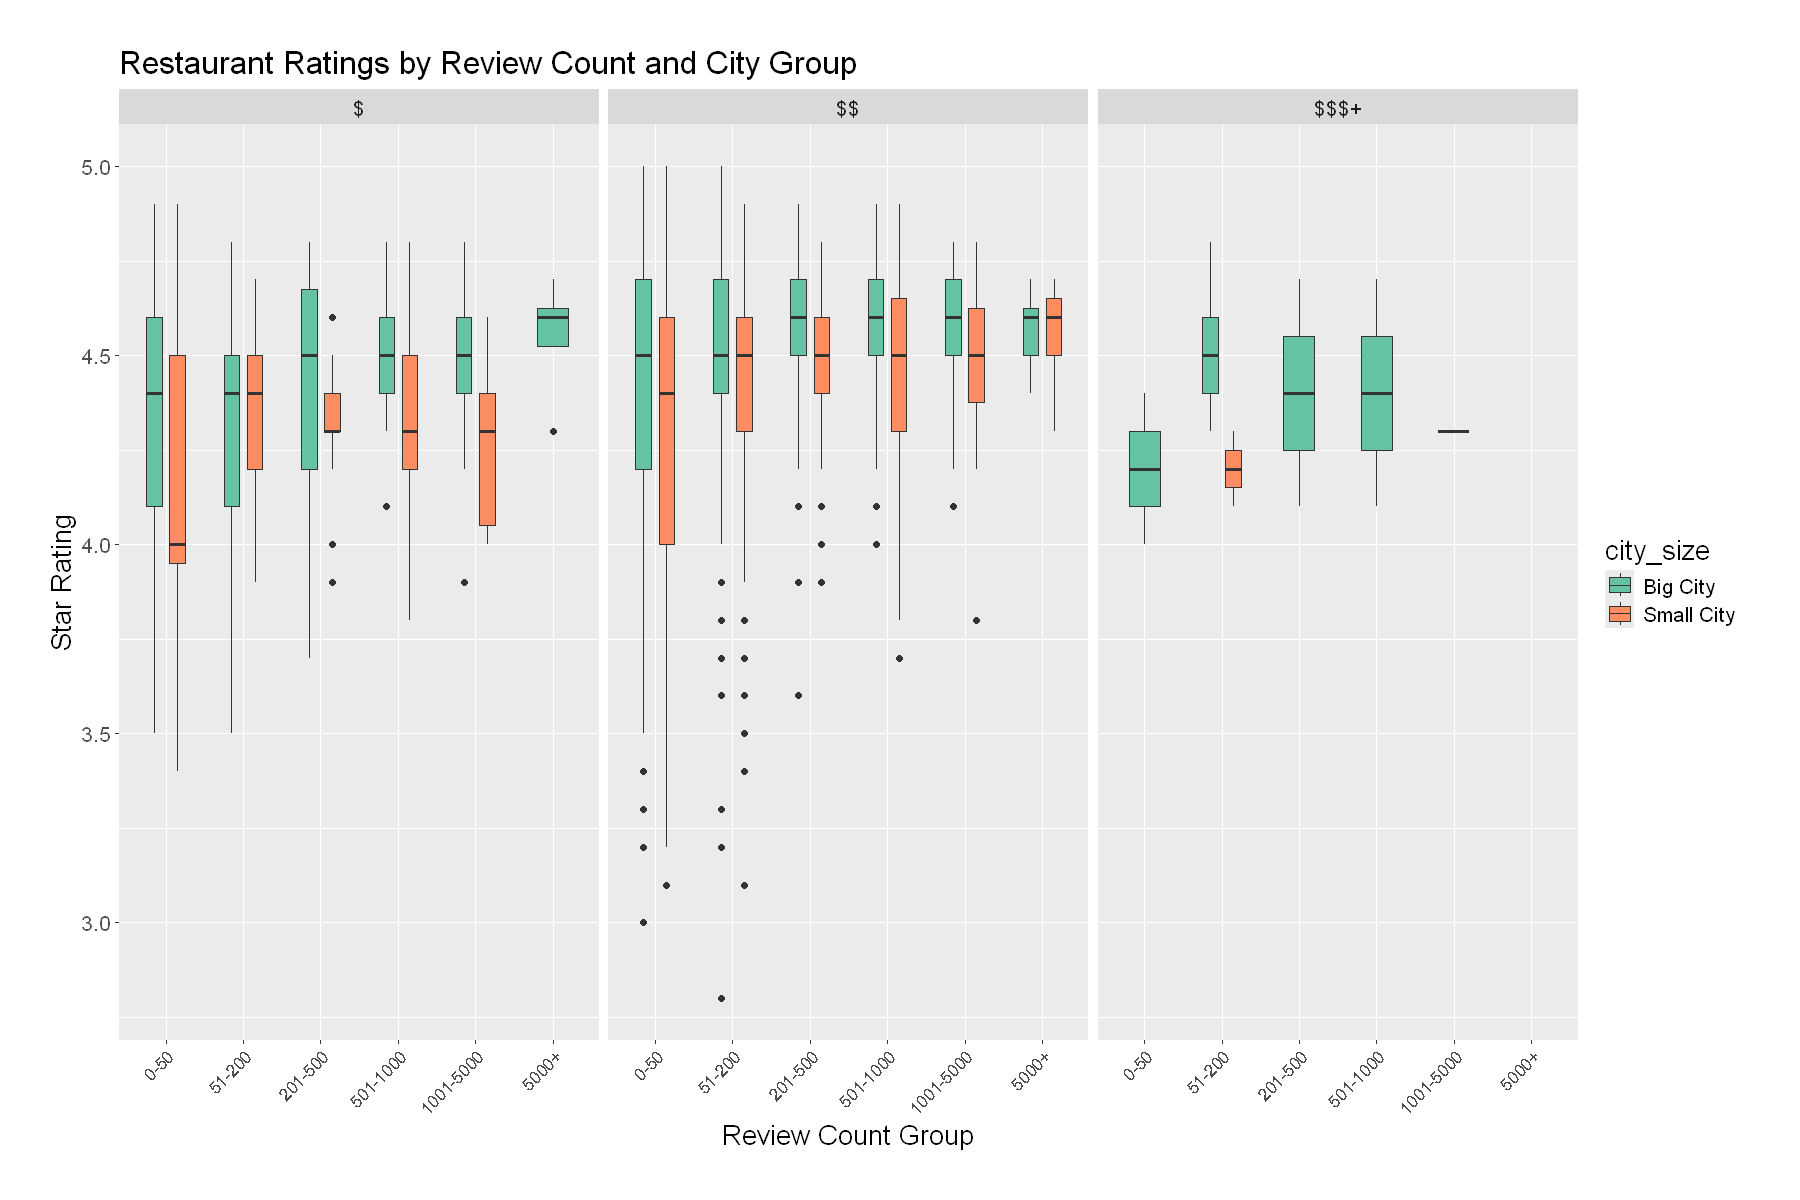

In [16]:
options(repr.plot.width = 15, repr.plot.height = 10)


visualize_data <- cleaned_data %>%
    mutate(review_group = cut(num_reviews,
                            breaks = c(0, 50, 200, 500, 1000, 5000, Inf),
                            labels = c("0-50", "51-200", "201-500", "501-1000", "1001-5000", "5000+")))

ggplot(visualize_data, aes(x = review_group, y = star, fill = city_size)) +
    geom_boxplot(position = position_dodge(width = 0.6), width = 0.4) +
    facet_grid(~ price_range) +
    labs(title = "Restaurant Ratings by Review Count and City Group",
         x = "Review Count Group",
         y = "Star Rating") +
    theme(text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
          plot.margin = margin(30, 30, 30, 30)) +
  scale_fill_brewer(palette = "Set2")


**!!! Description:**

Figure 4: Heatmap of all inputs


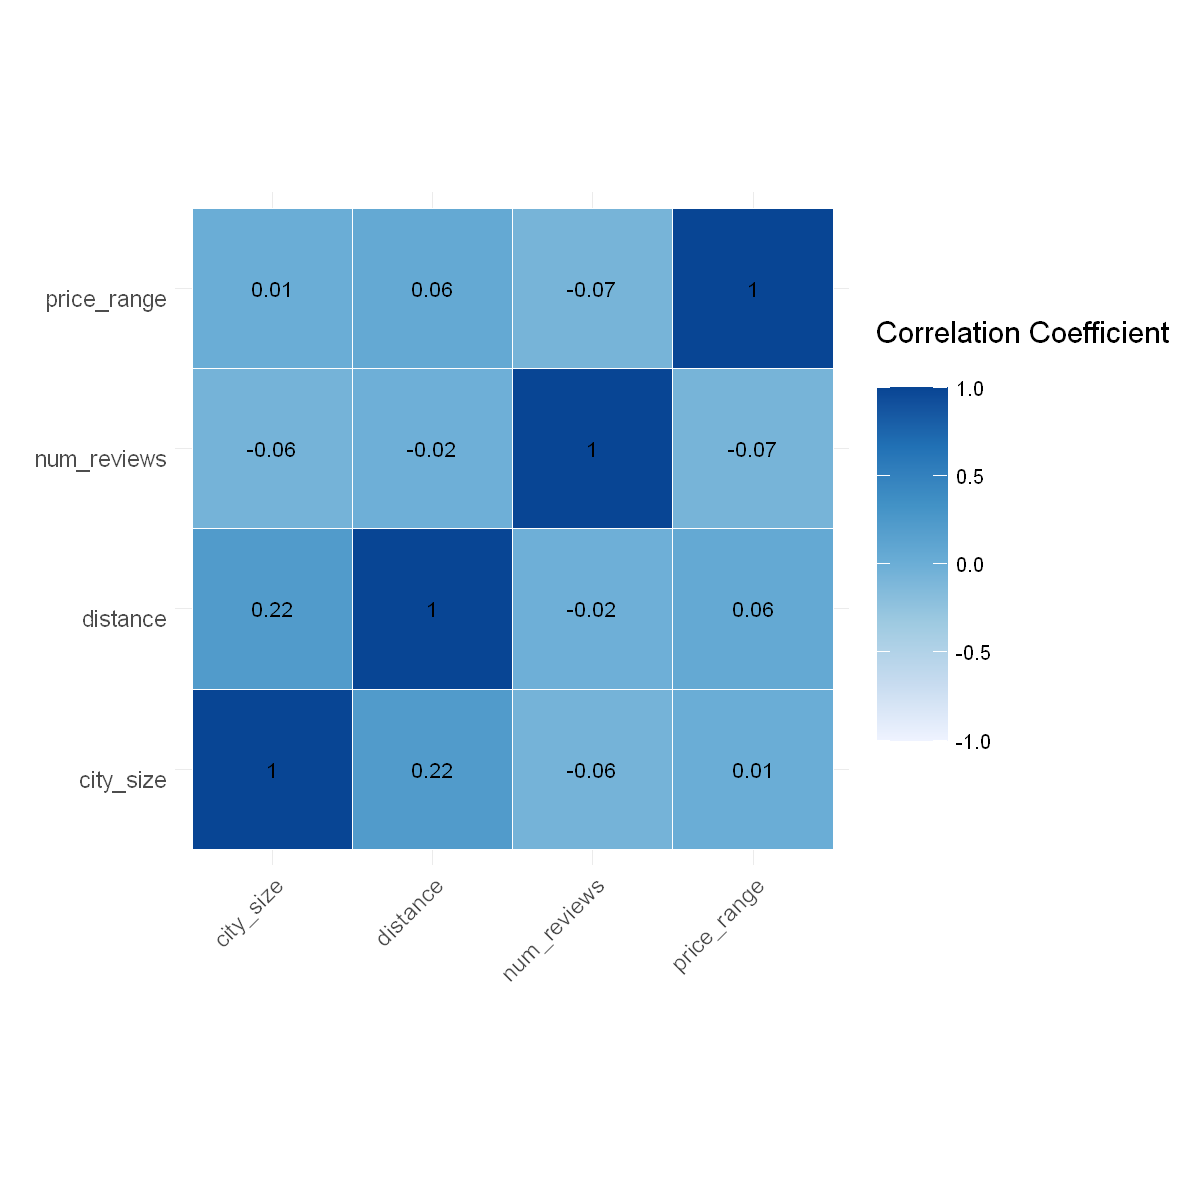

In [17]:
options(repr.plot.width = 10, repr.plot.height = 10)


# Calculate the correlation
corr_matrix <- cleaned_data %>%
  mutate(price_range = as.numeric(factor(price_range)),
         city_size = as.numeric(factor(city_size))) %>%
  select(-star) %>%
  select(where(is.numeric)) %>%
  cor() %>%
  as_tibble(rownames = 'var1') %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

# plot the heatmap
corr_plot <- corr_matrix %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
                         palette = "Blues",
                         direction = 1, 
                         limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
corr_plot

cat("Figure 4: Heatmap of all inputs\n")

The correlation between these 4 variables is reasonable and all are less than 0.3, indicating low multicollinearity and the potential for combined predictive power.

#### Part C: Methods

`Summary` We aim to identify the best combination of inputs that yield the best prediction using stepwise selection with linear regression.

### Why this method?
`Backward Stepwise Selection` 
- We use **backward selection** to filter true features that really matter. This method produces the simple regression model, which enhances **interpretability**.
- The process is **deterministic** and provides clear and consistent results.

`Linear Regression`
- Linear regression is necessary because it is highly interpretable. The coefficient $\beta_j$ directly represent the change in 
$Y_i$ for a unit change in $x_i$.
- Interaction terms can be explicitly added to the model.
- Linear regression is computationally efficient and straightforward to implement.

`Assumptions`are essential for the method selected:

Applying Linear Least Square Regression requires several assumptions to ensure validity:
- **Linearity**: The expected value of the response variable (star rating) is a linear combination of the explanatory variables.
- **Independence**: The errors are independent, i.e., $\mathbb{E}[\epsilon] = 0$.
- **Normality**: The errors (not the response itself) are normally distributed at each level of the covariates.
- **Equal Variance**: The standard deviation of the responses is equal for all levels of covariates (homoscedasticity).
- **Adequate Sample Size**: Assumes a sufficiently large sample size to ensure reliable estimation of the model parameters.

`Potential limitation and weaknesses`
- Interaction terms may introduce multicollinearity, leading to unstable standard errors.
- Stepwise selection is a greedy method that can overfit the training data; cross-validation is necessary to assess model performance.
- Including many interaction terms can reduce model interpretability.
- The model may be limited by the data itself, as star ratings can be high even with few reviews, suggesting nonlinearity or unobserved factors not captured by the available features.

#### Part D: Implementation of a proposed model: computational code and output

In [13]:
# Split the data into two subsets
data_split <- initial_split(cleaned_data, prop = 0.7, strata = star)
training_set <- training(data_split)
testing_set <- testing(data_split)

We use backward stepwise selection to find the best attributes for star rating prediction.  Using model fit criteria such as adjusted R-squared, the strategy begins with all variables and gradually eliminates the least helpful ones.  We chose this approach because it strikes a compromise between predictive strength and model simplicity, and it performs well when interpretability is crucial.

In [14]:
backward_selection <- regsubsets(star ~ distance + num_reviews + price_range + city_size, 
                                 data = training_set, 
                                 nvmax = 4, 
                                 method = "backward")

backward_summary <- summary(backward_selection)
backward_summary

Subset selection object
Call: regsubsets.formula(star ~ distance + num_reviews + price_range + 
    city_size, data = training_set, nvmax = 4, method = "backward")
5 Variables  (and intercept)
                    Forced in Forced out
distance                FALSE      FALSE
num_reviews             FALSE      FALSE
price_range$$           FALSE      FALSE
price_range$$$+         FALSE      FALSE
city_sizeSmall City     FALSE      FALSE
1 subsets of each size up to 4
Selection Algorithm: backward
         distance num_reviews price_range$$ price_range$$$+ city_sizeSmall City
1  ( 1 ) " "      " "         " "           " "             "*"                
2  ( 1 ) " "      " "         "*"           " "             "*"                
3  ( 1 ) " "      "*"         "*"           " "             "*"                
4  ( 1 ) "*"      "*"         "*"           " "             "*"                

The number of reviews, price range, and city size were the most significant predictors of restaurant star ratings, according to the findings of the backward selection process.  num_reviews, a mid-range pricing (price_range$$), and whether the restaurant was situated in a small city were all included in the ideal three-variable model, indicating that evaluations are influenced by both popularity and location factors.

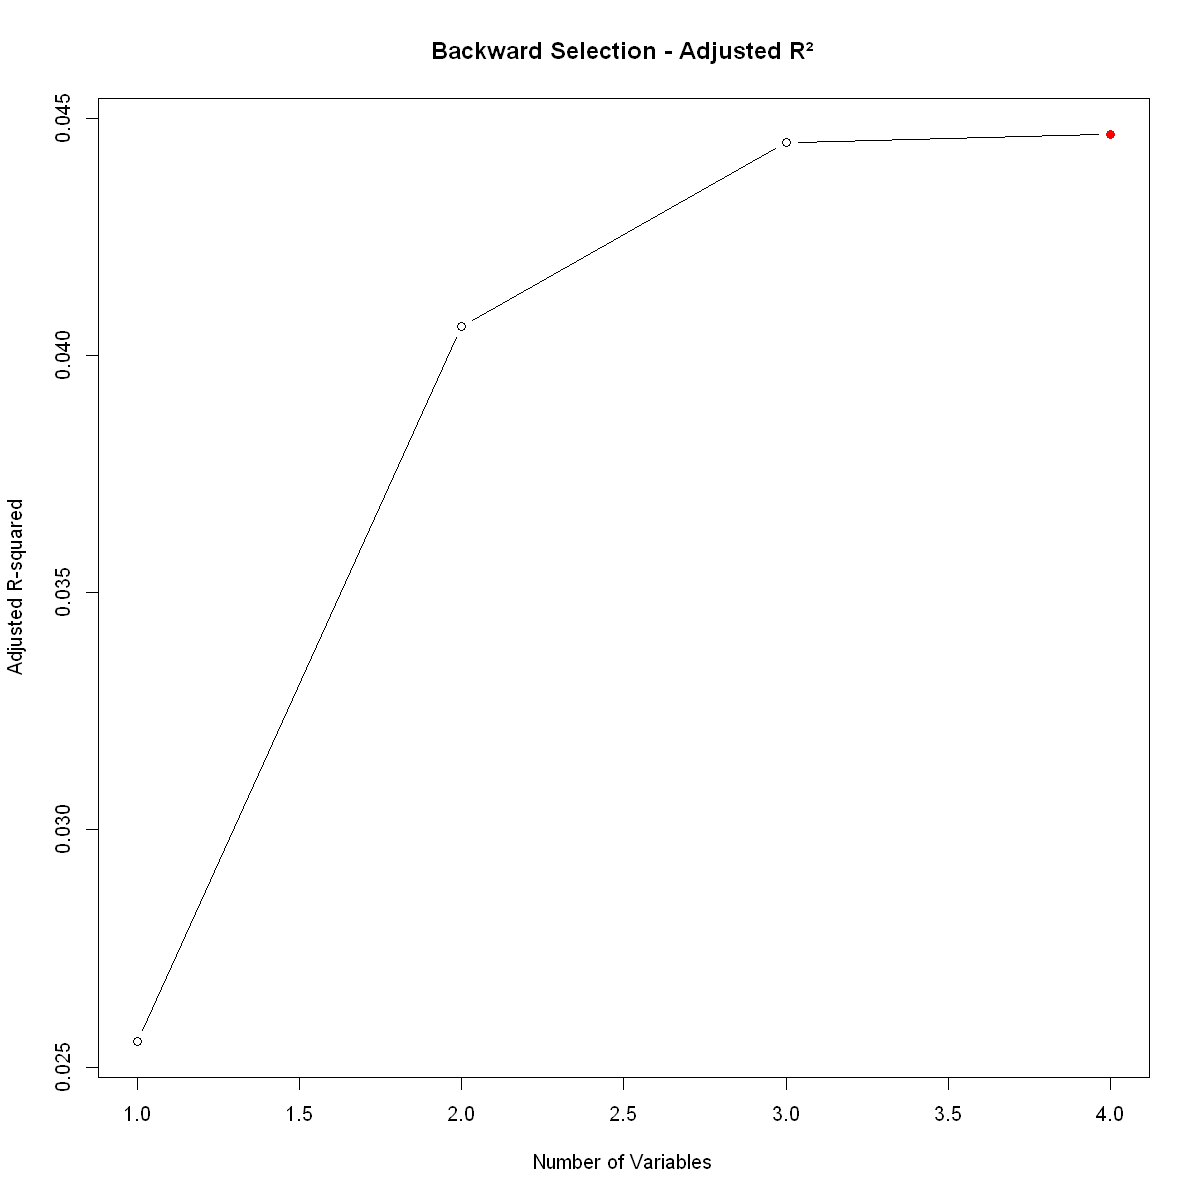

In [15]:
par(bg = "white", col.axis = "black", col.lab = "black", col.main = "black")

plot(backward_summary$adjr2, type = "b", 
     xlab = "Number of Variables", ylab = "Adjusted R-squared", 
     main = "Backward Selection - Adjusted R²")
best_size <- which.max(backward_summary$adjr2)
points(best_size, backward_summary$adjr2[best_size], col = "red", pch = 19)

This plot shows how the adjusted R-squared changes as more variables are included in the model using backward stepwise selection. The peak occurs at three variables, indicating the optimal balance between model complexity and explanatory power. Including more than three variables slightly reduces adjusted R-squared, suggesting that additional predictors do not meaningfully improve the model and may add unnecessary complexity.

In [8]:
mlr_model <- lm(star ~ num_reviews + price_range + city_size, data = training_set)

mlr_gof <- glance(mlr_model) |> round(3)
mlr_gof

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.041,0.039,0.271,19.677,0,4,-202.243,416.485,449.564,133.764,1827,1832


With an R-squared of 0.041 and an adjusted R-squared of 0.039 for the training set, the multiple linear regression model only partially explains the variance in restaurant star ratings.  The model is statistically significant (F = 19.60, p < 0.001), indicating that the predictors together make a considerable contribution to the response variable, even with the low explanatory power.

We employed root mean squared error (RMSE), mean absolute error (MAE), and R-squared as metrics to assess the multiple linear regression model's performance on the test set.  With an RMSE of 0.262 and an MAE of 0.197, the model produced star ratings with a comparatively low average prediction error.  Nonetheless, the R-squared value was around 0.040, indicating that the model only accounts for roughly 4% of the ratings' variation. This is in line with previous findings and emphasizes the features' poor predictive ability.

In [9]:
predictions <- predict(mlr_model, newdata = testing_set)

library(yardstick)
results <- data.frame(
  truth = testing_set$star,
  estimate = predictions
)

metrics(results, truth = truth, estimate = estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.2778880
rsq,standard,0.0402350
mae,standard,0.2027196


## 3. Discussion

##### **Results/Implications**

1. RMSE:
- The Root Mean Squared Error, which measures the average magnitude of the errors between the predicted and observed values, is 0.2778880. This indicates that, on average, the model's predictions are 0.277 ~ star ratings away from the correct star rating. 
- The relatively low RMSE indicates that the model does a reasonable job of predicting the Star Rating for door-dash restaurants. 
2. R^2:
- The R-squared of the model measures the proportion of the variance in the dependent variable explained by our model. 
- In our case, the R-squared of 0.04 is very low, indicating that only about 4% of the variation in star rating is explained by our model alone. Given the extremely low R-squared, we must conclude that the model is a poor fit for the data or that the variables used do not contain enough information to explain the variation in star ratings. 
3. Mean Absolute Error:
- The Mean Absolute Error measures the differences between the predicted and actual values. It is similar to RMSE but differs in that it does not penalize large errors. 
The MAE for our model is 0.2027. This indicates that, on average, the model's predictions for star rating are incorrect by 0.203 stars from the true values recorded in the test set. 

##### **Expectations**

Overall, the low explanatory power of the model was expected. This is because of the extremely limited information contained in the dataset. Remember that our model was restricted because the dataset only contained four reasonably consistent variables (price range, city size, distance, and number_reviews). Furthermore, certain variables, such as distance, were poorly defined and inconsistently recorded. However, despite the low explanatory power of the model, the model's predictive power was relatively strong, given that the RMSE was less than a 1-star point, indicating that, on average, the model would be able to predict a restaurant's star rating within a 1-star rating. 

##### **Improvements**

The main issue with our model would be the lack of information and data used to train the model. If we had more consistent and better-documented data, such as consistent data on the type of food served, number of orders, portion sizes, and wait time, we could construct a model that better explains and predicts star ratings. Furthermore, the choice of model, namely Linear Regression, could be swapped out for a better model because Star Rating (our dependent variable) is not necessarily numerical. Rather, a Star rating is an integer measurement that could be interpreted as ordinal, given that five stars are ordered higher and better than those below it. For example, an Ordinal Logistic Regression model could arguably better fit our question. 

##### **Future Questions and Research**

Future research built upon the findings here could shift their focus toward understanding customer demographics and/or the impact social media or other online platforms have on the star ratings of a restaurant. For example, the elderly and youths may have different preferences, which could affect a restaurant's star rating that specifically targets or caters to a certain demographic group. Furthermore, given the online nature of Doordash, social media will have a noticeable impact on the popularity and indirectly on a restaurant's star rating. It would be interesting to see how the virality of a restaurant affects its overall performance and ratings. 

## 4. References

Dataset Citation:
Data source: Satoshi_S. (2022). Food delivery in Canada (Door Dash) [Data set]. Kaggle. https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash

Mohamadabadi, T. A., Nazarian-Jashnabadi, J., Daryani, M. A., Al-Rashid, M. A., & Campisi, T. (2024). Factors affecting online customer experience of food delivery services during crisis: TISM and Delphi techniques. *Sustainable Futures*, 100408. https://doi.org/10.1016/j.sftr.2024.100408

Selvaraj, C., & Nallasivam, A. (2023). Reflection of star ratings on online customer reviews; its influence on consumer Decision-Making. In *Lecture notes in networks and systems* (pp. 107–128). https://doi.org/10.1007/978-981-19-6634-7_9